# Advanced Machine Learning - Project

## Imported libraries

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

## Import the data

### 1. Core Features

- ## **Lagged Returns**  
  (*Return* 𝑡−1, *Return* 𝑡−2, …)

    **a. For SVM and Neural Networks:**

    **Nonlinear Relationships:**

    SVMs and NNs can capture complex, nonlinear dependencies between lagged returns and future returns.
    Lagged returns provide the primary input for these models to learn patterns such as momentum or mean-reversion.

    **Feature Engineering:**

    Financial time series data often exhibit dependencies where past values (lagged returns) help predict future values.
    Without lagged returns, SVMs and NNs will lack meaningful input features.

    **b. For ARMA (or ARIMA):**

    **Model Assumption:**

    ARMA processes explicitly model dependencies in time series data using lagged values (AR part) and errors (MA part).
    By default, ARMA relies on past observations and residuals, making lagged returns a natural input for comparison.

    **Direct Comparison:**

    By including lagged returns as input features for SVM and NNs, the dataset aligns conceptually with the ARMA model, which inherently uses lagged terms.


- ## **Volatility** (e.g., rolling 10-day standard deviation)

  Why it's useful: Markets tend to exhibit volatility clustering, where high-volatility periods are followed by more high-volatility periods, and low-volatility periods follow low-volatility periods.

### 2. Key Technical Indicators

- ## **Simple Moving Averages (SMA)**  
  - ${SMA}_5, {SMA}_{20}$

    ### What is SMA (Simple Moving Average)?
    The **Simple Moving Average (SMA)** is a technical indicator that calculates the average of a given data set (e.g., prices or returns) over a specified number of periods. It smooths out price data to identify trends over time.

    #### Formula for SMA
    $$\text{SMA}_t = \frac{P_{t-1} + P_{t-2} + \ldots + P_{t-N}}{N}$$

    Where:
    -  $P_{t-1}, P_{t-2}, \ldots, P_{t-N}$  are the prices for the most recent $N$ periods.
    -  $N$ is the window size (e.g., 10 days, 20 days).

    ---

    ### Why Use SMA as a Feature?
    SMA is a powerful feature in financial modeling due to its ability to capture market trends. Here's why:

    #### 1. Identifies Trends
    - SMA smooths out short-term price fluctuations, helping to identify the overall direction of the market.
    - **Example**: A rising SMA indicates an upward trend, while a declining SMA indicates a downward trend.

    #### 2. Acts as a Support/Resistance Level
    - Many traders and investors view SMA as a key support or resistance level:
      - **Above SMA**: Bullish signal (uptrend).
      - **Below SMA**: Bearish signal (downtrend).

    #### 3. Helps in Detecting Momentum
    - By comparing short-term and long-term SMAs (e.g., 10-day vs. 50-day SMA), you can identify momentum:
      - **Golden Cross**: Short-term SMA crosses above long-term SMA (bullish signal).
      - **Death Cross**: Short-term SMA crosses below long-term SMA (bearish signal).

    #### 4. Useful in Mean-Reversion Strategies
    - Prices often revert to their mean after deviating significantly. SMA can act as a proxy for this mean, helping to predict reversals.

    ---

    ### How Does SMA Enhance Predictive Models?

    #### 1. Trend Representation
    - SMA captures underlying trends that are not evident from raw prices or returns alone.

    #### 2. Momentum and Reversal Patterns
    - Combining SMA with lagged returns or volatility provides insights into both momentum and mean-reversion behaviors.

    #### 3. Risk Reduction
    - Including SMA as a feature reduces the noise in price data, making it easier for models to focus on significant patterns.


- ## **RSI** - 14-day

    ### What is RSI (Relative Strength Index)?

    The **Relative Strength Index (RSI)** is a momentum oscillator used in technical analysis to measure the speed and magnitude of recent price changes. It evaluates overbought or oversold conditions in a market. RSI values range from **0 to 100**.

    #### RSI Formula
    $$\text{RSI} = 100 - \left( \frac{100}{1 + RS} \right)$$
    Where:
    - $$ RS = \frac{\text{Average Gain (over n periods)}}{\text{Average Loss (over n periods)}} $$

    ##### Key Levels
    - **70 and above**: Overbought (price might decrease).
    - **30 and below**: Oversold (price might increase).

    ---

    ### Why RSI is Useful as a Feature?

    #### 1. Detects Momentum and Reversals
    - RSI highlights periods of strong momentum (overbought/oversold) that can predict potential reversals:
      - High RSI (overbought): Indicates a possible downward reversal.
      - Low RSI (oversold): Indicates a possible upward reversal.

    #### 2. Captures Market Sentiment
    - RSI quantifies the balance between buying and selling pressure, serving as a proxy for market sentiment.
      - **Bullish Sentiment**: RSI rising above 50.
      - **Bearish Sentiment**: RSI falling below 50.

    #### 3. Enhances Predictive Power for Returns
    - Since RSI reflects momentum and trend strength, it complements lagged returns and volatility, helping models like SVM and Neural Networks better understand market dynamics.

    #### 4. Widely Used in Trading Strategies
    - RSI is a staple in trading algorithms for designing momentum and mean-reversion strategies.

    ---

    ### How RSI Relates to Predicting Returns
    - **Momentum Signals**: RSI provides momentum signals that help in understanding whether returns are likely to continue in the same direction or reverse.
    - **Reversion to Mean**: RSI-based signals often align with mean-reversion patterns, making it relevant for predicting returns.

    ---

    ### Comparison to Other Features

    | **Feature**           | **Primary Insight**               | **Why Complement RSI?**                        |
    |------------------------|-----------------------------------|------------------------------------------------|
    | **Lagged Returns**     | Historical return dependencies.  | RSI captures trend/momentum beyond raw returns.|
    | **Volatility (StdDev)**| Magnitude of price movement.     | RSI adds directional bias to magnitude data.   |
    | **SMA**                | Long-term/Short-term smoothed trends.       | RSI detects short-term overbought/oversold.    |

    ---


### 3. Macroeconomic and Market Sentiment

- **VIX Index**  
  - (daily value)

- **1 or 2 macroeconomic variables most relevant to your time frame**  
  - (e.g., Treasury yields and CPI)

### 4. Day-of-Week Effects

- **Include dummy variables for the day of the week**


In [1]:
%run process_data.py

[*********************100%***********************]  1 of 1 completed

S&P 500 data processed.
Data saved as 'processed_data.csv'.


## **Processing of the dataset**

In [2]:
data = pd.read_csv('data/processed_data.csv', index_col=0)
data.head()

,Close,returns,Volume,Volume_lag_1,volatility_lag_10,SMA_10,SMA_20,RSI_14,Lag_1,Lag_2,Lag_3
Date,,,,,,,,,,,
2005-02-02,1193.189941,0.003178,1561740000,1.681980e+09,0.006390,-0.000532,-0.000510,56.851350,0.006891,0.008460,-0.002716
2005-02-03,1189.890015,-0.002766,1554460000,1.561740e+09,0.005627,0.000734,0.000233,49.545744,0.003178,0.006891,0.008460
2005-02-04,1203.030029,0.011043,1648160000,1.554460e+09,0.004968,0.001236,0.000276,53.586131,-0.002766,0.003178,0.006891
2005-02-07,1201.719971,-0.001089,1347270000,1.648160e+09,0.005048,0.002982,0.000653,53.112474,0.011043,-0.002766,0.003178
2005-02-08,1202.300049,0.000483,1416170000,1.347270e+09,0.004748,0.003226,0.000670,43.980153,-0.001089,0.011043,-0.002766


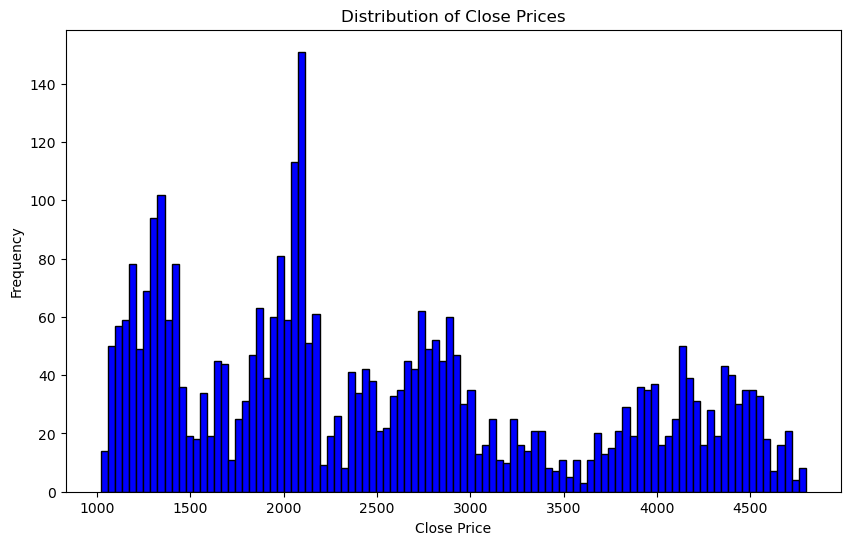

In [48]:
plt.figure(figsize=(10, 6))
plt.hist(data['Close'], bins=100, color='blue', edgecolor='black')
plt.xlabel('Close Price')
plt.ylabel('Frequency')
plt.title('Distribution of Close Prices')
plt.show()

In [4]:
# Define the features (X) and target (y)
X = data.drop(columns=['returns'])  # All columns except the target
y = data['returns']                 # The target column

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Print shapes of the resulting splits
print(f"Training features shape: {X_train.shape}")
print(f"Testing features shape: {X_test.shape}")
print(f"Training target shape: {y_train.shape}")
print(f"Testing target shape: {y_test.shape}")

Training features shape: (2800, 11)
Testing features shape: (701, 11)
Training target shape: (2800,)
Testing target shape: (701,)


## **1. Financial Time series (ARIMA/ARIMAX)**

In [40]:
# Select the target variable (returns)
train_returns = y_train  # Training target
test_returns = y_test    # Testing target

result = adfuller(train_returns.dropna())
print(f"p-value: {result[1]}")

p-value: 1.3248234630917157e-21


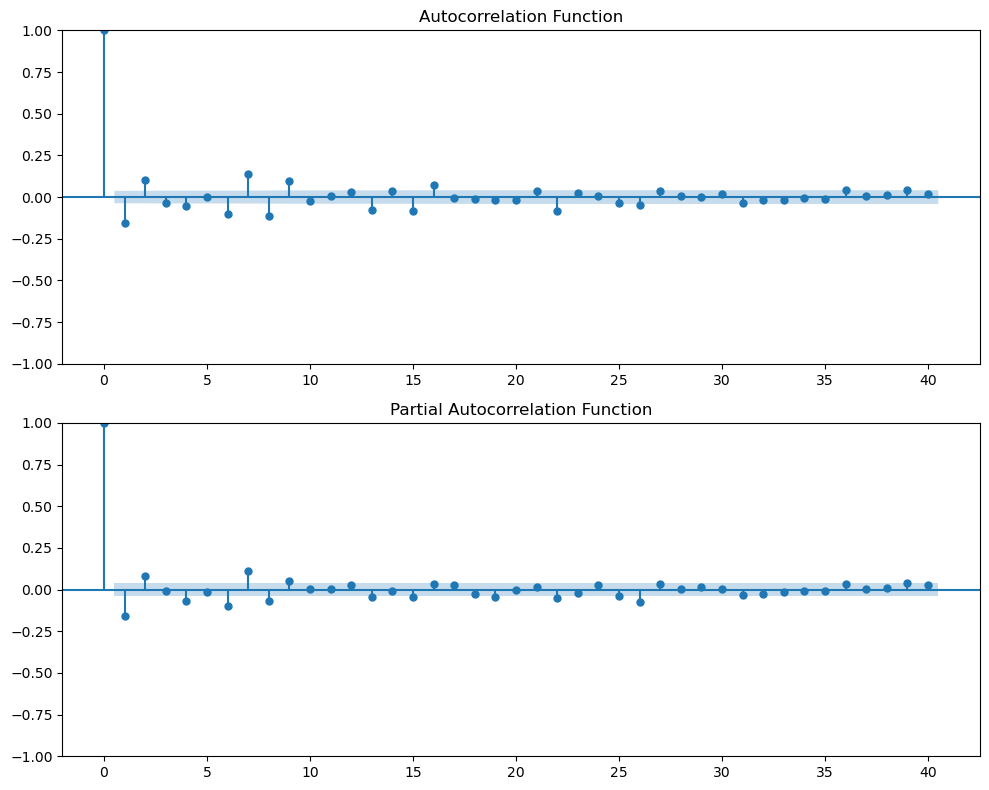

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(train_returns, ax=ax[0], lags=40, title="Autocorrelation Function")
plot_pacf(train_returns, ax=ax[1], lags=40, title="Partial Autocorrelation Function")
plt.tight_layout()
plt.show()

### Grid search of the best parameters for the ARIMA Model

In [13]:
import itertools
import warnings
warnings.filterwarnings("ignore")  # Suppress ARIMA warnings during grid search

In [67]:
import itertools
import warnings
warnings.filterwarnings("ignore")  # Suppress ARIMA warnings during grid search

# Extend parameter ranges
p = d = q = range(0, 5)  # Increase range
pdq = list(itertools.product(p, d, q))

best_aic = float("inf")
best_pdq_arima = None

for param in tqdm(pdq):
    try:
        model = ARIMA(train_returns, order=param)
        model_fit = model.fit()
        if model_fit.aic < best_aic:
            best_aic = model_fit.aic
            best_pdq_arima = param
    except:
        continue

print(f"Optimal parameters: {best_pdq_arima}")


100%|██████████| 125/125 [03:23<00:00,  1.63s/it]

Optimal parameters: (3, 1, 3)


In [50]:
# Fit ARIMA model on training data
#model = ARIMA(train_returns, order=best_pdq_arima)
model = ARIMA(train_returns, order=(1,0,1))
model_fit = model.fit()

# Print summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 2800
Model:                 ARIMA(1, 0, 1)   Log Likelihood                8691.567
Date:                Sun, 29 Dec 2024   AIC                         -17375.133
Time:                        19:51:37   BIC                         -17351.384
Sample:                             0   HQIC                        -17366.560
                               - 2800                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      2.602      0.009       0.000       0.001
ar.L1         -0.5743      0.031    -18.586      0.000      -0.635      -0.514
ma.L1          0.4300      0.034     12.644      0.0

In [51]:
# Forecast for the test set period
forecast = model_fit.forecast(steps=len(test_returns))

# Evaluate the model
mse = mean_squared_error(test_returns, forecast)
r2 = r2_score(test_returns, forecast)

print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")


Mean Squared Error: 0.00012408292846207732
R² Score: -0.0007246676177399269


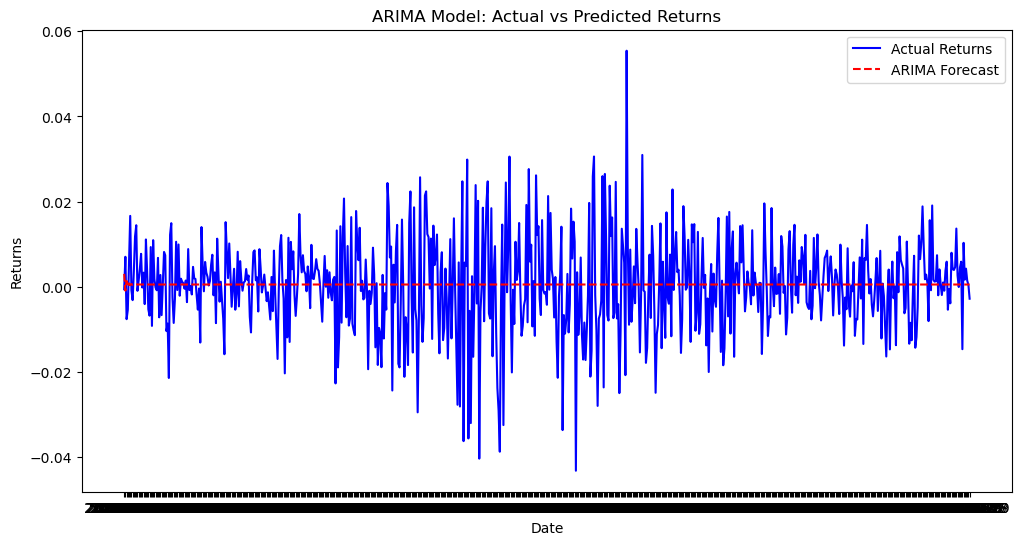

In [52]:
# Plot the actual vs predicted returns
plt.figure(figsize=(12, 6))
plt.plot(test_returns.index, test_returns, label="Actual Returns", color="blue")
plt.plot(test_returns.index, forecast, label="ARIMA Forecast", color="red", linestyle="--")
plt.title("ARIMA Model: Actual vs Predicted Returns")
plt.xlabel("Date")
plt.ylabel("Returns")
plt.legend()
plt.show()


### Grid Search for the ARIMAX Model

In [43]:
# Extend parameter ranges
exog_cols = ['Volume_lag_1', 'volatility_lag_10', 'SMA_10','SMA_20', 'RSI_14', 'Lag_1','Lag_2', 'Lag_3']
#exog_cols = ['Volume', 'volatility_lag_10', 'SMA_10','SMA_20', 'RSI_14', 'Lag_1','Lag_2', 'Lag_3' ]

p = d = q = range(0, 3)  # Increase range
pdq = list(itertools.product(p, d, q))

best_mse = float("inf")
best_pdq_arimax = None

for param in tqdm(pdq):
    try:
        model = model = ARIMA(train_returns, exog=X_train[exog_cols], order=param)
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=len(test_returns), exog=X_test[exog_cols])
        mse = mean_squared_error(test_returns, forecast)
        if mse < best_mse:
            best_mse = mse
            best_pdq_arimax = param
    except:
        continue

print(f"Optimal parameters: {best_pdq_arimax}")

100%|██████████| 27/27 [00:47<00:00,  1.76s/it]

Optimal parameters: (1, 0, 1)


In [48]:
model = ARIMA(train_returns, exog=X_train[exog_cols], order=best_pdq_arimax)
#model = ARIMA(train_returns, exog=X_train[exog_cols], order=(1,0,1))
model_fit = model.fit()
forecast = model_fit.forecast(steps=len(X_test), exog=X_test[exog_cols])

mse_arimax = mean_squared_error(y_test, forecast)
r2_arimax = r2_score(y_test, forecast)
print(f"Mean Squared Error: {mse_arimax}")
print(f"R² Score: {r2_arimax}")

Mean Squared Error: 0.00012875961222319946
R² Score: -0.03844196572158509


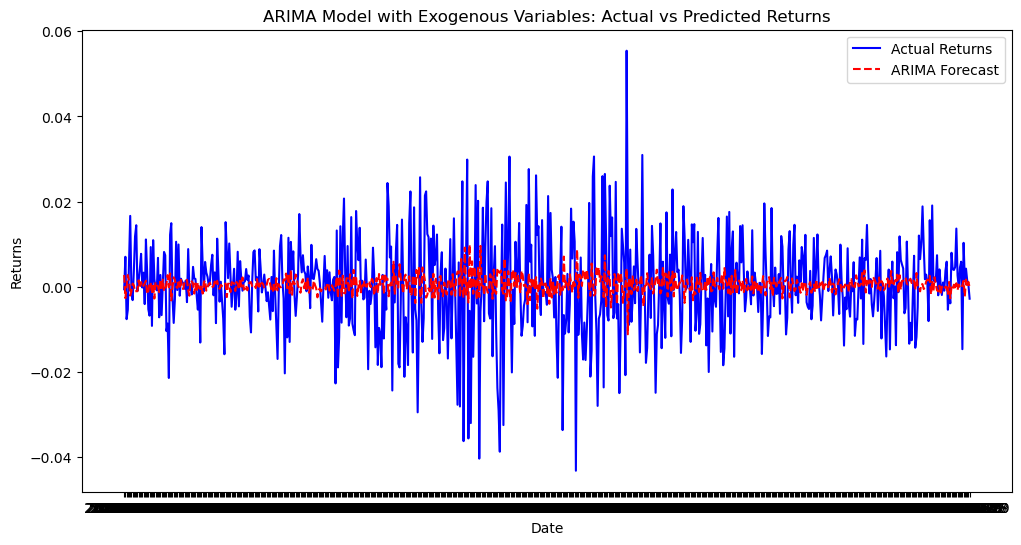

In [49]:
plt.figure(figsize=(12, 6))
plt.plot(test_returns.index, test_returns, label="Actual Returns", color="blue")
plt.plot(test_returns.index, forecast, label="ARIMA Forecast", color="red", linestyle="--")
plt.title("ARIMA Model with Exogenous Variables: Actual vs Predicted Returns")
plt.xlabel("Date")
plt.ylabel("Returns")
plt.legend()
plt.show()

## **2. Support Vector Machine (SVM)**

In [5]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit the scaler only on the training set
X_test_scaled = scaler.transform(X_test)        # Use the same scaler for the testing set

/Users/jimmybao/anaconda/anaconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


Mean Squared Error: 0.00012453713800354734
R² Score: -0.004387852376917634


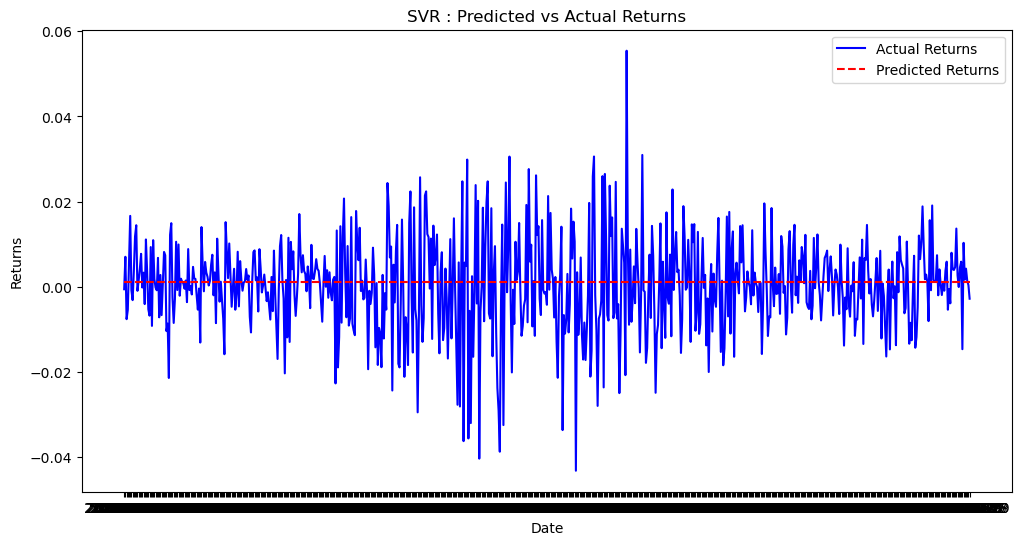

In [20]:
# Initialize SVR model
svr = SVR(kernel='rbf', C=10, epsilon=0.01)

# Fit the model
svr.fit(X_train_scaled, y_train)

# Predict on test data
y_pred = svr.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")

# Plot predictions vs actual
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label="Actual Returns", color="blue")
plt.plot(y_test.index, y_pred, label="Predicted Returns", color="red", linestyle="--")
plt.title("SVR : Predicted vs Actual Returns")
plt.xlabel("Date")
plt.ylabel("Returns")
plt.legend()
plt.show()


In [12]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'C': [0.01, 0.1, 1],
    'gamma': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 1],
    #'kernel': ['rbf', 'linear', 'poly']
}

# Initialize GridSearchCV
grid = GridSearchCV(SVR(kernel='rbf'), param_grid, scoring='neg_mean_squared_error', cv=3)
grid.fit(X_train_scaled, y_train)

# Best parameters
print("Best parameters:", grid.best_params_)

# Evaluate on the test set
best_svr = grid.best_estimator_
y_pred = best_svr.predict(X_test_scaled)

Best parameters: {'C': 0.01, 'epsilon': 0.01, 'gamma': 1}


Mean Squared Error: 0.0001243327356364381
R² Score: -0.0027393541232016982


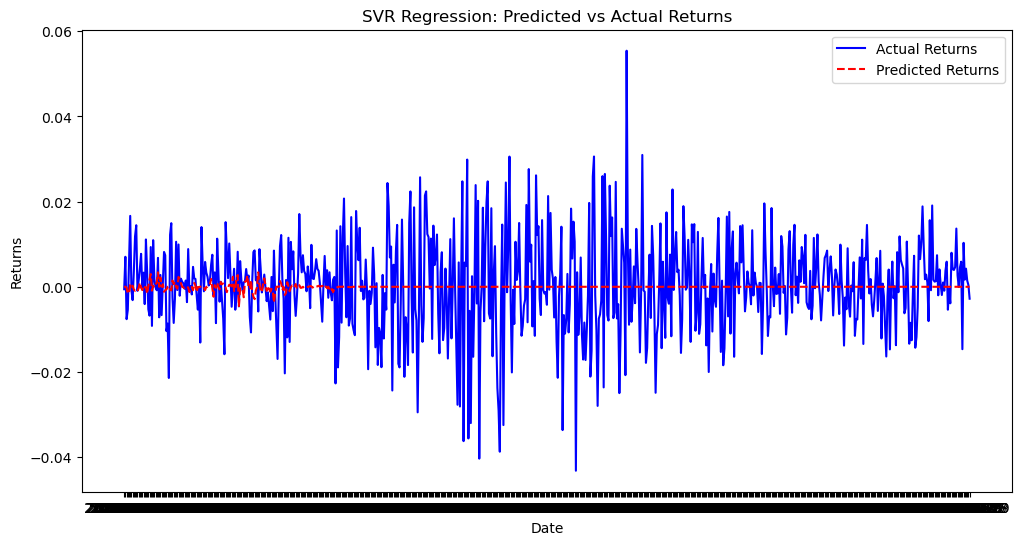

In [13]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")

# Plot predictions vs actual
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label="Actual Returns", color="blue")
plt.plot(y_test.index, y_pred, label="Predicted Returns", color="red", linestyle="--")
plt.title("SVR Regression: Predicted vs Actual Returns")
plt.xlabel("Date")
plt.ylabel("Returns")
plt.legend()
plt.show()
